# Starbucks Data Analysis Project

The problem that I chose to solve was to build a model that predicts whether a customer will respond to a Starbucks offer.
The data set that I will be using for my analysis is simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.
Not all users receive the same offer, and that is the challenge to solve with this data set.
My task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.
Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. In the data set informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.
I have extracted transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.
I also kept in mind that someone using the app might make a purchase through the app without having received an offer or seen an offer.
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.
However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.
Aim is to build a machine learning model that could help predicting which customer will actually use the offer.



The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.).
profile.json - demographic data for each customer .
transcript.json - records for transactions, offers received, offers viewed, and offers completed.
Here is the schema and explanation of each variable in the files:
#
portfolio.json

id (string) - offer id.
offer_type (string) - the type of offer ie BOGO, discount, informational.
difficulty (int) - the minimum required to spend to complete an offer.
reward (int) - the reward is given for completing an offer.
duration (int) - time for the offer to be open, in days.
channels (list of strings).
#
profile.json

age (int) - age of the customer.
became_member_on (int) - the date when customer created an app account.
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F).
id (str) - customer id.
income (float) - customer's income.
#
transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.).
person (str) - customer id.
time (int) - time in hours since the start of the test. The data begins at time t=0.
value - (dict of strings) - either an offer id or transaction amount depending on the record.


In [9]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [5]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Cleaning the portfolio dataframe

In [8]:
# Changing the duration column values from days to hours
new_portfolio = portfolio.copy()
new_portfolio['duration'] = new_portfolio['duration'] * 24

# Applying one hot encoding to the channels column
new_portfolio['web'] = new_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
new_portfolio['email'] = new_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
new_portfolio['mobile'] = new_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
new_portfolio['social'] = new_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
# apply one hot encoding to offer_type column
offer_type = pd.get_dummies(new_portfolio['offer_type'])
    
# drop the channels and offer_type column
new_portfolio.drop(['channels'], axis=1, inplace=True)
    
# combine the portfolio and offer_type dataframe to form a cleaned dataframe
new_portfolio = pd.concat([new_portfolio, offer_type], axis=1, sort=False)

new_portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


# Cleaning the profile dataframe

In [9]:
#check for null values 
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
profile[profile['age']== 118].age.count()

2175

According to the description of the profile data frame and checking null values, it looks like values of gender & income are missing where age is 118. To confirm, I'll print the values with age 118.

In [11]:
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


Thus, it is confirmed that both gender & income for the age 118 are missing. All missing age values are encoded as 118

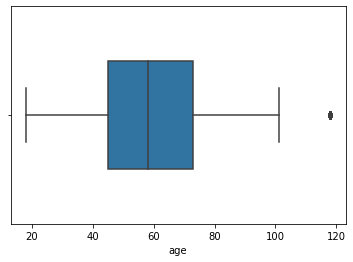

In [12]:
sns.boxplot(profile['age'], width=0.5);

It seems to be like people with age greater than 80 don't use the app much or they may not drink much beverages. So, I consider people with the above age as outliers.

# Merging the  transcript and profile datasets

In [13]:
#merge the transcript and the profile datasets
df = transcript.merge(profile, left_on='person', right_on='id', how='outer')
df.head()

,person,event,value,time,gender,age,id,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0


In [14]:
null_profile = df[df['gender'].isnull()]
len(null_profile)

33772

In [15]:
#null profile offer completion rate
null_rate = len(null_profile[null_profile['event']=='offer completed'])/len(null_profile[null_profile['event']=='offer received'])

print(null_rate)

0.11610065466448445


Now let us find out what is the offer completion rate for non null profiles.

In [16]:
not_null_profile=df[df['gender'].notnull()]
not_null_rate = len(not_null_profile[not_null_profile['event']=='offer completed'])/len(not_null_profile[not_null_profile['event']=='offer received'])

print(not_null_rate)

0.4878723628216117


The profiles which have null values in their profile have less offer completion rate so , I will be dropping the null values for my analysis.

In [17]:
#dropping null values
new_df = df[df['gender'].notnull()].copy()
new_df.drop('id', axis=1, inplace=True) 

In [18]:
#changing became_member_on to the datetime format
new_df['became_member_on'] = pd.to_datetime(new_df['became_member_on'], format='%Y%m%d')

#creating a new column that has the year which customers became members 
new_df['year'] = new_df['became_member_on'].apply(lambda x: str(x)[:4])
    
#changing the time in hours to days and also rounding up
new_df['days'] = new_df['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
    
#cleaning the value column
new_df['offer_id'] = new_df['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'] if 'offer_id' in x else np.nan)
new_df['amount'] = new_df['value'].apply(lambda x: x.get('amount', 0))
new_df.drop(['value'], axis=1, inplace=True)
    
new_df = new_df.reset_index(drop=True)

In [19]:
new_df.head()

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,2017-05-09,100000.0,2017,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,2017-05-09,100000.0,2017,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,2017-05-09,100000.0,2017,6,NaN,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,2017-05-09,100000.0,2017,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,2017-05-09,100000.0,2017,6,NaN,17.78


In [20]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272762 entries, 0 to 272761
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   time              272762 non-null  int64         
 3   gender            272762 non-null  object        
 4   age               272762 non-null  int64         
 5   became_member_on  272762 non-null  datetime64[ns]
 6   income            272762 non-null  float64       
 7   year              272762 non-null  object        
 8   days              272762 non-null  int64         
 9   offer_id          148805 non-null  object        
 10  amount            272762 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 22.9+ MB


In [21]:
new_portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [22]:
new_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reward         10 non-null     int64 
 1   difficulty     10 non-null     int64 
 2   duration       10 non-null     int64 
 3   offer_type     10 non-null     object
 4   id             10 non-null     object
 5   web            10 non-null     int64 
 6   email          10 non-null     int64 
 7   mobile         10 non-null     int64 
 8   social         10 non-null     int64 
 9   bogo           10 non-null     uint8 
 10  discount       10 non-null     uint8 
 11  informational  10 non-null     uint8 
dtypes: int64(7), object(2), uint8(3)
memory usage: 878.0+ bytes


In [23]:
full_df = new_df.merge(new_portfolio, left_on='offer_id', right_on='id', how='outer')
full_df.drop(['id'], axis=1, inplace=True)

In [24]:
full_df.head(20)

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,2017-05-09,100000.0,2017,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,2017-05-09,100000.0,2017,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,2017-05-09,100000.0,2017,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,e2127556f4f64592b11af22de27a7932,offer received,408,M,68,2018-04-26,70000.0,2018,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,M,68,2018-04-26,70000.0,2018,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
5,e2127556f4f64592b11af22de27a7932,offer completed,522,M,68,2018-04-26,70000.0,2018,22,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
6,389bc3fa690240e798340f5a15918d5c,offer received,168,M,65,2018-02-09,53000.0,2018,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,389bc3fa690240e798340f5a15918d5c,offer viewed,192,M,65,2018-02-09,53000.0,2018,8,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
8,389bc3fa690240e798340f5a15918d5c,offer received,408,M,65,2018-02-09,53000.0,2018,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
9,389bc3fa690240e798340f5a15918d5c,offer viewed,438,M,65,2018-02-09,53000.0,2018,19,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,168.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [25]:
#Let's see the orders of the variables
print( (full_df['event'].unique()), full_df['gender'].unique(), full_df['year'].unique())

['offer received' 'offer viewed' 'offer completed' 'transaction'] ['F' 'M' 'O'] ['2017' '2018' '2015' '2016' '2014' '2013']


Turning categorical data to numbers

event - 0-'offer received'

1-'offer viewed'

2-'offer completed'

3-'transaction'

gender -

0-F

1-M

2-O

year -

0-'2013'

1-'2014'

2-'2015'

3-'2016'

4-'2017'

5-'2018'

offer_type

0-bogo

1-informational

2-discount

In [26]:
# Dataframe with old columns + additional columns that turned categorial variables into numbers.The numbers only indicates different categories, not orders.
def cate2num(df, cols):
       for col in cols:
        #get all the unique categories in the column
        array = df[col].unique()
        
        #get the numbers of categories
        value_nums = len(array)
        
        #create new column
        df[col+'_id'] = df[col]

        for i in range(value_nums):
            #replace the variable with a number in the newly created column
            df[col+'_id'] = np.where(df[col]==array[i] , i, df[col+'_id'])
    
        return df

In [27]:
def clean_allcat(df, cols):

    cleaned_df = cate2num(df, cols)
    
    #years
    years = df['year'].unique()
    year_sorted = sorted([int(x) for x in list(years)])
    cleaned_df['year_id'] = df['year']
    for i in range(len(year_sorted)):
        cleaned_df['year_id'] = np.where(cleaned_df['year_id']==str(year_sorted[i]) , i, cleaned_df['year_id'])

    return cleaned_df

In [28]:
full_clean = clean_allcat(full_df, ['gender'])
full_clean = clean_allcat(full_clean, ['event'])
full_clean.head()

,person,event,time,gender,age,became_member_on,income,year,days,offer_id,...,web,email,mobile,social,bogo,discount,informational,gender_id,year_id,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,2017-05-09,100000.0,2017,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,4,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,2017-05-09,100000.0,2017,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,4,1
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,2017-05-09,100000.0,2017,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,4,2
3,e2127556f4f64592b11af22de27a7932,offer received,408,M,68,2018-04-26,70000.0,2018,17,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1,5,0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,M,68,2018-04-26,70000.0,2018,18,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1,5,1


In [29]:
full_clean['interacted'] = 1
person_all_offers = full_clean.groupby(['person', 'offer_id','event'])['interacted'].max().unstack(fill_value=0)

#if a person (did not use an offer) or (used it without viewing), then the offer is wasted
person_all_offers['wasted'] = np.where((person_all_offers["offer completed"]==1)&(person_all_offers["offer viewed"]==1), 0, 1)
person_all_offers

event                                                              offer completed  \
person                           offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                1   
                                 3f207df678b143eea3cee63160fa8bed                0   
                                 5a8bc65990b245e5a138643cd4eb9837                0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   
...                                                                            ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d                1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7                1   
                                 2906b810c7d4411798c6938adc9daaa5                1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                1   
                                 fafdcd668e3743c1bb461111dcafc2a4                1   

event                                                              offer received  \
person                           offer_id                                           
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5               1   
                                 3f207df678b143eea3cee63160fa8bed               1   
                                 5a8bc65990b245e5a138643cd4eb9837               1   
                                 f19421c1d4aa40978ebb69ca19b0e20d               1   
                                 fafdcd668e3743c1bb461111dcafc2a4               1   
...                                                                           ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d               1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7               1   
                                 2906b810c7d4411798c6938adc9daaa5               1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9               1   
                                 fafdcd668e3743c1bb461111dcafc2a4               1   

event                                                              offer viewed  \
person                           offer_id                                         
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5             0   
                                 3f207df678b143eea3cee63160fa8bed             1   
                                 5a8bc65990b245e5a138643cd4eb9837             1   
                                 f19421c1d4aa40978ebb69ca19b0e20d             1   
                                 fafdcd668e3743c1bb461111dcafc2a4             1   
...                                                                         ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d             1   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7             1   
                                 2906b810c7d4411798c6938adc9daaa5             1   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9             1   
                                 fafdcd668e3743c1bb461111dcafc2a4             1   

event                                                              wasted  
person                           offer_id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       1  
                                 3f207df678b143eea3cee63160fa8bed       1  
                                 5a8bc65990b245e5a138643cd4eb9837       1  
                                 f19421c1d4aa40978ebb69ca19b0e20d       0  
                                 fafdcd668e3743c1bb461111dcafc2a4       0  
...                                                                   ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d       0  
ffff82501ce

In [30]:
#creating a new dataframe with only the information that we need to build the model
model_df = person_all_offers['wasted']
model_df.reset_index(level=['person', 'offer_id'])
model_df= model_df.to_frame().reset_index()
model_df.head()

,person,offer_id,wasted
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0


In [31]:
df=pd.merge(model_df, full_clean, how='inner', sort=True)

In [32]:
df = clean_allcat(df, [ 'offer_type'])
df = clean_allcat(df, [ 'offer_id'])
df.drop(['gender', 'offer_type', 'offer_id', 'year','event','time','became_member_on','year','days','amount','interacted'], axis=1, inplace=True)

In [33]:
df.head()

,person,wasted,age,income,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational,gender_id,year_id,event_id,offer_type_id,offer_id_id
0,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2.0,10.0,168.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1,4,0,0,0
1,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2.0,10.0,168.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1,4,2,0,0
2,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0.0,0.0,96.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,4,0,1,1
3,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0.0,0.0,96.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,4,1,1,1
4,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0.0,0.0,72.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,4,0,1,2


# EDA

Text(0.5, 0, 'Income')

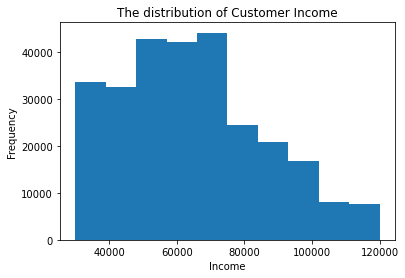

In [34]:
cust_income = full_clean['income'].plot(kind='hist', bins=10, title='The distribution of Customer Income')
cust_income.set_xlabel("Income")

Max number of Customers have income ranging between 50000-70000.

Text(0.5, 0, 'Customer Age')

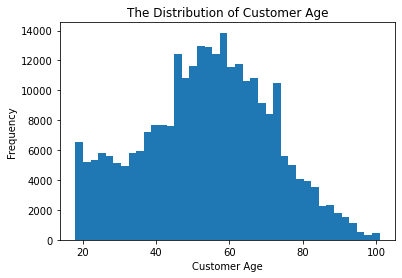

In [35]:
cust_age = full_clean['age'].plot(kind='hist', bins=40, title='The Distribution of Customer Age')
cust_age.set_xlabel("Customer Age")

Seems that the age group 45-60 is the most common in customers.

In [36]:
full_clean[(full_clean['age'] > 80) & (full_clean['age'] < 102)]['age'].count()

17807

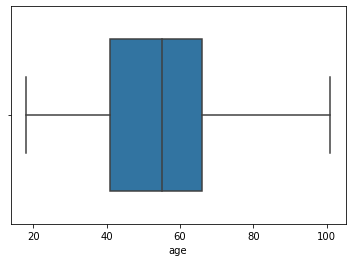

In [37]:
sns.boxplot(full_clean['age'], width=0.7)

It seems that like people with age greater than 80 don't use the app much or they may not drink much beverages. So, I will be considering people with the above age as outliers.

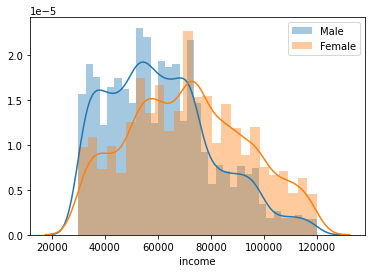

In [38]:
# Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()


Discount success rate:  64.45394539453946  Bogo success rate:  57.497079549308516


Text(0.5, 1.0, 'Success percentages for bogo and discount offers')

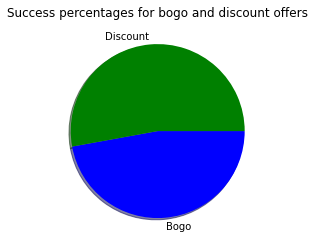

In [39]:
success_bogo=((full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer completed')]['event'].count())/(full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer received')]['event'].count())) *100
success_discount=((full_clean[(full_clean['discount']==1.0)&(full_clean['event']=='offer completed')]['event'].count())/(full_clean[(full_clean['discount']==1.0)&(full_clean['event']=='offer received')]['event'].count())) *100
print('Discount success rate: ',success_discount,' Bogo success rate: ',success_bogo)
plt.pie([success_bogo,success_discount],colors=['blue', 'green'], labels=['Bogo', 'Discount'] ,counterclock=False, shadow=True)
plt.title('Success percentages for bogo and discount offers')

Discount offer is more popular because not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. However, BOGO offer has a much greater chance to be viewed or seen by customers.

But this percentage might include the cases when people did not view the offers but completed them unknowingly.

([<matplotlib.patches.Wedge at 0x21a4b27ba90>,
 [Text(-0.24762902922809168, -1.0717648360921126, 'Male'),
  Text(0.19924591390285712, 1.0818045413997002, 'Female'),
  Text(1.098890122095961, 0.049401412529646305, 'Other')])

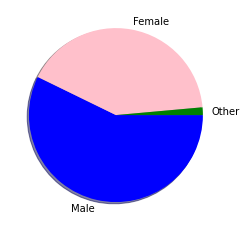

In [40]:
plt.pie(profile['gender'].value_counts(), colors=['blue', 'pink', 'green'], labels=['Male', 'Female', 'Other'], counterclock=False, shadow=True)

I will be considering only females and males for the simpicity of my further analysis because anyway the other category customers are a very small number.

Female success bogo:  68.34624145785877 ,Male success bogo:  49.39505523408732


Text(0.5, 1.0, 'Buy one get one free offer success percentages')

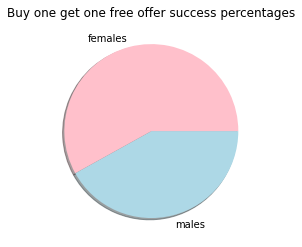

In [41]:
male_bogo_received=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer received')&(full_clean['gender_id']==1)]['event'].count()
male_bogo_completed=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer completed')&(full_clean['gender_id']==1)]['event'].count()
female_bogo_received=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer received')&(full_clean['gender_id']==0)]['event'].count()
female_bogo_completed=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer completed')&(full_clean['gender_id']==0)]['event'].count()
female_success_bogo=((female_bogo_completed)/(female_bogo_received)) *100
male_success_bogo=((male_bogo_completed)/(male_bogo_received)) *100

print('Female success bogo: ',female_success_bogo,',Male success bogo: ',male_success_bogo)

plt.pie([male_success_bogo,female_success_bogo],colors=['lightblue', 'pink'], labels=['males', 'females'] ,counterclock=False, shadow=True)
plt.title('Buy one get one free offer success percentages')


Females are more likely to complete the bogo offer and males have a low offer completion rate

Female success discount:  72.88677693502696 ,Male success discount:  49.39505523408732


Text(0.5, 1.0, 'Discount offer success percentages')

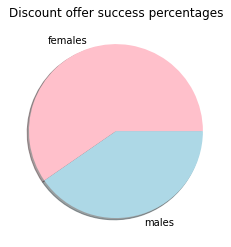

In [42]:
male_discount_received=full_clean[(full_clean['discount']==1.0)&(full_clean['event']=='offer received')&(full_clean['gender_id']==1)]['event'].count()
male_discount_completed=full_clean[(full_clean['discount']==1.0)&(full_clean['event']=='offer completed')&(full_clean['gender_id']==1)]['event'].count()
female_discount_received=full_clean[(full_clean['discount']==1.0)&(full_clean['event']=='offer received')&(full_clean['gender_id']==0)]['event'].count()
female_discount_completed=full_clean[(full_clean['discount']==1.0)&(full_clean['event']=='offer completed')&(full_clean['gender_id']==0)]['event'].count()
female_success_discount=((female_discount_completed)/(female_discount_received)) *100
male_success_discount=((male_bogo_completed)/(male_bogo_received)) *100

print('Female success discount: ',female_success_discount,',Male success discount: ',male_success_discount)

plt.pie([male_success_discount,female_success_discount],colors=['lightblue', 'pink'], labels=['males', 'females'] ,counterclock=False, shadow=True)
plt.title('Discount offer success percentages')

Female:  83.30751708428245 , Male:  82.72619673855866


Text(0.5, 1.0, 'Gender likely to view a discount offer')

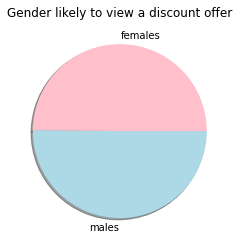

In [43]:
male_bogo_viewed=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer viewed')&(full_clean['gender_id']==1)]['event'].count()
female_bogo_viewed=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer viewed')&(full_clean['gender_id']==0)]['event'].count()
male_bogo_received=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer received')&(full_clean['gender_id']==1)]['event'].count()
female_bogo_received=full_clean[(full_clean['bogo']==1.0)&(full_clean['event']=='offer received')&(full_clean['gender_id']==0)]['event'].count()
female_success_bogo=((female_bogo_viewed)/(female_bogo_received)) *100
male_success_bogo=((male_bogo_viewed)/(male_bogo_received)) *100

print('Female: ',female_success_bogo,', Male: ',male_success_bogo)

plt.pie([female_success_bogo,male_success_bogo],colors=['lightblue', 'pink'], labels=['males', 'females'] ,counterclock=False, shadow=True)
plt.title('Gender likely to view a discount offer')

The males represent 62.7% of the data and use the Starbucks app more than the females. Specifically, both males & females in the age group 45-60 use app the most. Discount offers are more preferred by the customers.

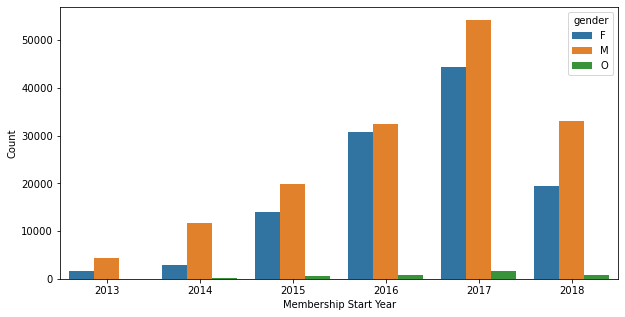

In [44]:
# groupby start_year and gender to plot a graph
full_clean['start_year'] = full_clean.became_member_on.dt.year
membership_date = full_clean.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

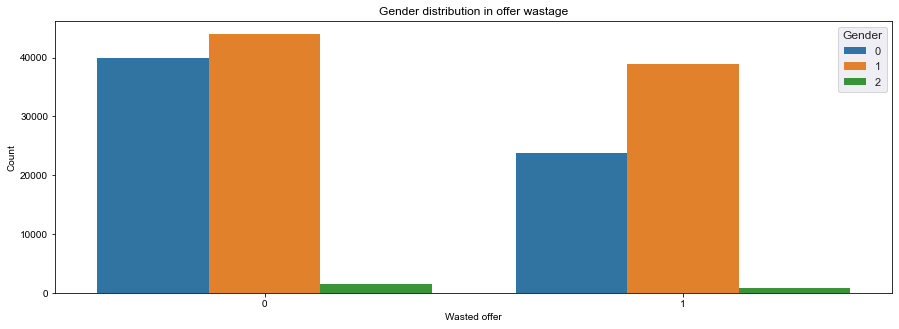

In [45]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "wasted", hue= "gender_id", data=df)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer wastage')
plt.ylabel('Count')
plt.xlabel('Wasted offer')
plt.legend(title='Gender')

gender -

0-Female

1-Male

2-Other

Wasted offer:

0-No

1-Yes

Text(0.5, 0, 'Wasted offer')

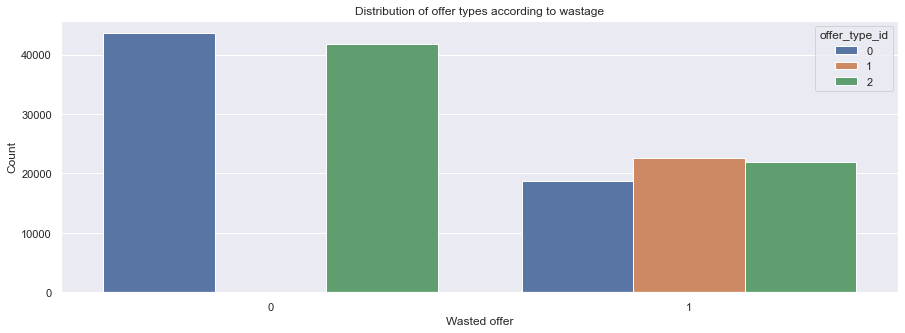

In [46]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "wasted", hue= "offer_type_id", data=df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types according to wastage')
plt.ylabel('Count')
plt.xlabel('Wasted offer')

Offer types:

0-bogo

1-informational

2-discount

Wasted offer:

0-No

1-Yes


Text(0.5, 0, 'Wasted offer')

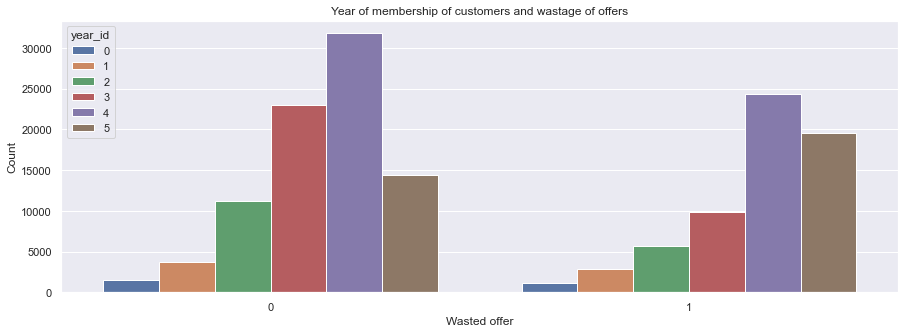

In [47]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "wasted", hue= "year_id", data=df)
sns.set(style="darkgrid")
plt.title('Year of membership of customers and wastage of offers')
plt.ylabel('Count')
plt.xlabel('Wasted offer')

year -

0-'2013'

1-'2014'

2-'2015'

3-'2016'

4-'2017'

5-'2018'

Text(0.5, 0, 'Wasted offer')

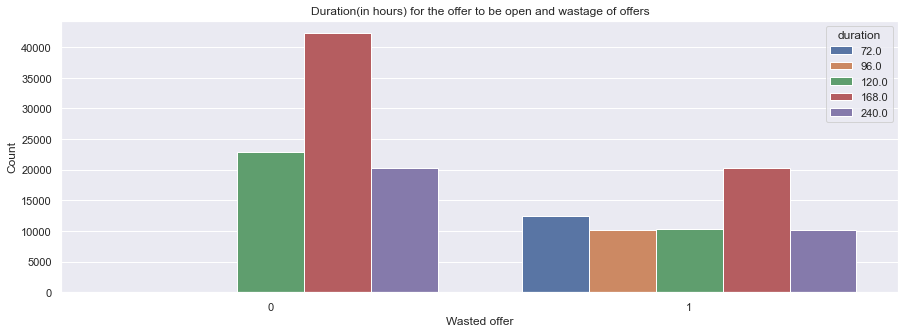

In [48]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "wasted", hue= "duration", data=df)
sns.set(style="darkgrid")
plt.title('Duration(in hours) for the offer to be open and wastage of offers')
plt.ylabel('Count')
plt.xlabel('Wasted offer')

The ideal time for the offer to be open should be 168 hours ie. 7 days for Less number of offers to be wasted 

Text(0.5, 1.0, 'Web offer Wastage ')

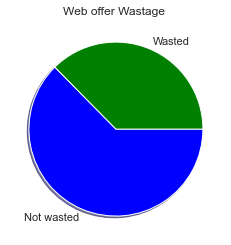

In [49]:
web_not_wasted=df[(df['wasted']==0)&(df['web']==1.0)]['web'].count()
web_wasted=df[(df['wasted']==1)&(df['web']==1.0)]['web'].count()
plt.pie([web_not_wasted,web_wasted],colors=['blue', 'green'], labels=['Not wasted', 'Wasted'] ,counterclock=False, shadow=True)
plt.title('Web offer Wastage ')

Text(0.5, 1.0, 'Email offer wastage ')

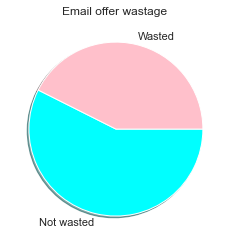

In [50]:
email_not_wasted=df[(df['wasted']==0)&(df['email']==1.0)]['web'].count()
email_wasted=df[(df['wasted']==1)&(df['email']==1.0)]['web'].count()
plt.pie([email_not_wasted,email_wasted],colors=['cyan', 'pink'], labels=['Not wasted', 'Wasted'] ,counterclock=False, shadow=True)
plt.title('Email offer wastage ')

Text(0.5, 1.0, 'Mobile offer wastage ')

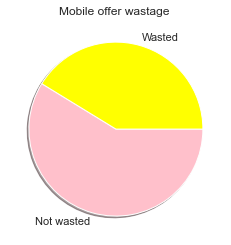

In [51]:
mobile_not_wasted=df[(df['wasted']==0)&(df['mobile']==1.0)]['web'].count()
mobile_wasted=df[(df['wasted']==1)&(df['mobile']==1.0)]['web'].count()
plt.pie([mobile_not_wasted,mobile_wasted],colors=['pink', 'yellow'], labels=['Not wasted', 'Wasted'] ,counterclock=False, shadow=True)
plt.title('Mobile offer wastage ')

Text(0.5, 1.0, 'Social offer wastage ')

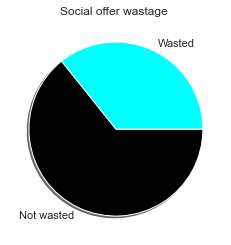

In [52]:
social_not_wasted=df[(df['wasted']==0)&(df['social']==1.0)]['web'].count()
social_wasted=df[(df['wasted']==1)&(df['social']==1.0)]['web'].count()
plt.pie([social_not_wasted,social_wasted],colors=['black', 'aqua'], labels=['Not wasted', 'Wasted'] ,counterclock=False, shadow=True)
plt.title('Social offer wastage ')

Less offers are wasted if sent through mobile or web

# Modelling and Evaluation 

In [53]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import time

In [54]:
#want to see how imbalanced is the dataset
df['wasted'].value_counts()

0    85429
1    63376
Name: wasted, dtype: int64

In [55]:
def model_prep(df):
    #data preperation
    label = df['wasted']
    train = df.iloc[:, 2:].copy()

    #Dividing the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(train, label,test_size=0.30, random_state=1)
    return X_train, X_test, y_train, y_test

In [56]:
X_train, X_test, y_train, y_test = model_prep(df)
#dummy model
dummy1 = DummyClassifier(random_state=1).fit(X_train, y_train)
pred_dummy1 = dummy1.predict(X_test)
print("randomly guessing score: {:.2f}".format(dummy1.score(X_test,y_test)))
dummy2 = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
pred_dummy2 = dummy2.predict(X_test)
print("guess all customers will stay score: {:.2f}".format(dummy2.score(X_test,y_test)))

randomly guessing score: 0.51
guess all customers will stay score: 0.57


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


This shows our class is nearly balanced

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("file1.csv")
df = df.iloc[: , 1:]
df.head()

,person,wasted,age,income,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational,gender_id,year_id,event_id,start_year,offer_type_id,offer_id_id
0,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2.0,10.0,168.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1,4,0,2017,0,0
1,0009655768c64bdeb2e877511632db8f,1,33,72000.0,2.0,10.0,168.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1,4,2,2017,0,0
2,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0.0,0.0,96.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,4,0,2017,1,1
3,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0.0,0.0,96.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,4,1,2017,1,1
4,0009655768c64bdeb2e877511632db8f,1,33,72000.0,0.0,0.0,72.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1,4,0,2017,1,2


# Model preparation

In [4]:
def model_prep(df):
    #data preperation
    label = df['wasted']
    train = df.iloc[:, 2:].copy()

    #Dividing the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(train, label,test_size=0.30, random_state=1)
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = model_prep(df)

# normalizing some numerical values
scaler=MinMaxScaler()

X_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(MinMaxScaler().fit_transform(X_test), columns=X_test.columns, index=X_test.index)


In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            
        }
    }     
}

In [ ]:
#Time:4 hrs(app)
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.to_csv('file2.csv')

In [8]:
import pandas as pd
dfd=pd.read_csv("file2.csv")
dfd=dfd.iloc[:,1:]
dfd

,model,best_score,best_params
0,svm,0.866556,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.859795,{'n_estimators': 10}
2,logistic_regression,0.826592,{'C': 5}
3,naive_bayes_gaussian,0.806707,{}
4,naive_bayes_multinomial,0.806659,{}
5,decision_tree,0.878007,{'criterion': 'entropy'}


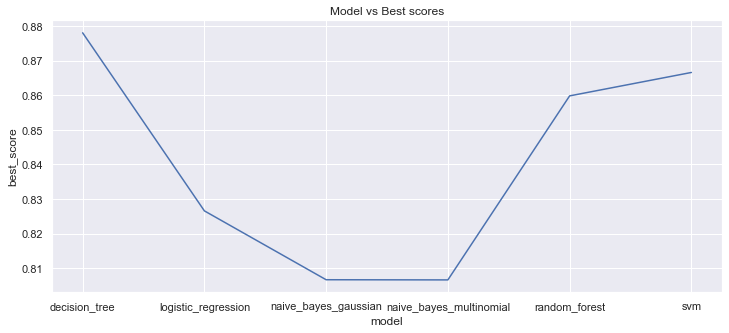

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
  
# draw lineplot
sns.lineplot(x="model", y="best_score", data=dfd).set_title('Model vs Best scores')

sns.set(rc={'figure.figsize':(12,5)})
plt.show()

# Conclusion

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer.

The following observations were made after the exploratory data analysis:

The age group 45-60 is the most common in customers. 
Most Customers have income ranging between 50000-70000.
Discount offer is more popular because not only the absolute number of 'offer completed' is slightly higher than BOGO offer, its overall completed/received rate is also about 7% higher. 

Females are more likely to complete the bogo or discount offer and males have a low offer completion rate
It seems to be that people with age greater than 80 don't use the app much or they may not drink many beverages. There is one entry for age 118. I will be considering it an outlier.

Buy one get one free offer is less likely to get wasted and most of the informational offers are most likely to get wasted.    
Customers who joined in 2017 are less likely to waste an offer. 

The ideal time for the offer to be open should be 168 hours ie. 7 days 
Less number of offers is wasted if offers are sent through social media or web.

The most common offer type among all age groups is the BOGO , followed by the Discount Offers. Whereas, the least common offer to be sent is the informational offers. I believe that BOGO offers are more attractive compared to other offers provided by Starbucks.

After splitting data to train and test datasets, I chose the best estimator "DecisionTreeClassifier" using GridSearch which is the best performing classifier algorithm among the above 6 classifiers tested. After performing hyper parameter tuning, I built the model. An accuracy of 87.8 was achieved by the model.
